In [1]:
import sympy as sp 
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy import units as u
from astropy import constants as const
from scipy import integrate

In [8]:
def get_moons_orbital_elements():
    """build the initial conditions of the moon from https://nssdc.gsfc.nasa.gov/planetary/factsheet/moonfact.html """
    semi_major_axis = 0.3844 * 1e6 * u.km
    eccentricity = 0.0549
    inclination = 5.145*u.deg
    return semi_major_axis, eccentricity, inclination

def set_units():
    # pick the units
    unitL = u.au
    unitT = u.yr
    unitV = unitL / unitT
    unitM = u.Msun
    unitG=unitV**2 * unitL / unitM
    G_val=const.G.to(unitG).value
    return unitL, unitT, unitV, unitM, unitG, G_val  

def compute_moons_initial_conditions(semi_major_axis,eccentricity,inclination,G_val,Mprimary):
    """
    Set the initial moon phase to be a full moon, or at x=1,y=0,z=~0
    """
    ra = (1+eccentricity) * semi_major_axis
    va = np.sqrt(G_val*Mprimary * (2/ra - 1/semi_major_axis))
    # put them in vectors 
    position_moon = np.array([ra, 0, 0])
    velocity_moon = np.array([0, va, 0])
    # rotate the position and velocity vectors by the inclination
    rotation_matrix = np.array([[1, 0, 0],
                                 [0, np.cos(inclination), -np.sin(inclination)],
                                 [0, np.sin(inclination), np.cos(inclination)]])
    position_moon = np.dot(rotation_matrix, position_moon)
    velocity_moon = np.dot(rotation_matrix, velocity_moon)
    return position_moon, velocity_moon


def get_unscaled_kepler_tidal_tensor_func():
    r,x,y,z=sp.symbols('r x y z', real=True)
    T = -sp.Matrix(
    [1 - 3*x**2/r**2, 
     -3*x*y/r**2, 
     -3*x*z/r**2,
     -3*x*y/r**2,
     1 - 3*y**2/r**2,
     -3*y*z/r**2,
     -3*x*z/r**2,
     -3*y*z/r**2,
     1 - 3*z**2/r**2])
    unscaled_tidal_tensor=T.reshape(3,3)
    unscaled_tidal_tensor_func = sp.lambdify((r, x, y, z), unscaled_tidal_tensor, "numpy")
    return unscaled_tidal_tensor_func


In [ ]:
def system_of_equations(t, y, G_val, Mearth, Dearth, omega, M_sun, unscaled_tidal_tensor_func):
    # unpack the state of the system 
    position_moon = y[:3]
    velocity_moon = y[3:]
    omega_vec = np.array([0, 0, omega])
    # get the current position of the earth
    x_earth = Dearth * np.cos(omega * t)
    y_earth = Dearth * np.sin(omega * t)
    z_earth = 0
    position_earth = np.array([x_earth, y_earth, z_earth])
    r_earth = np.linalg.norm(position_earth)
    # eval the tidal tensor at the position of the earth
    tidal_tensor = -(G_val*M_sun/r_earth**3)*unscaled_tidal_tensor_func(r_earth, position_earth[0], position_earth[1], position_earth[2])
    tidal_force = tidal_tensor.dot(position_moon)
    # evaluate the centrifugal force
    centrifugalforce = - np.cross(omega_vec, np.cross(omega_vec.T, position_moon.T).T)
    # evaluate the force from the earth
    moon_earth_distance = np.linalg.norm(position_moon)
    earth_force=-(G_val*Mearth / moon_earth_distance**3) * position_moon
    # get the net force 
    net_force = tidal_force + centrifugalforce + earth_force
    # stack up everything 
    ydot = np.concatenate([velocity_moon, net_force])
    return ydot

def two_body_rotating_frame_system_of_equations(t, y, G_val, Mearth, omega):
    # unpack the state of the system 
    position_moon = y[:3]
    velocity_moon = y[3:]
    omega_vec = np.array([0, 0, omega])
    # evaluate the centrifugal force
    centrifugalforce = - np.cross(omega_vec, np.cross(omega_vec.T, position_moon.T).T)
    # evaluate the force from the earth
    moon_earth_distance = np.linalg.norm(position_moon)
    earth_force=-(G_val*Mearth / moon_earth_distance**3) * position_moon
    # get the net force 
    net_force =  earth_force + centrifugalforce
    # stack up everything 
    ydot = np.concatenate([velocity_moon, net_force])
    return ydot

In [116]:
def sun_and_earth(unitL, unitT, unitM,):
    # get the earth and sun 
    Dearth = 1*unitL
    omega = 2*np.pi/(1*unitT) 
    M_sun = const.M_sun.to(unitM).value
    Mearth = const.M_earth.to(unitM).value
    Dearth = Dearth.to(unitL).value
    omega = omega.value
    return M_sun,  Mearth, Dearth, omega


In [117]:
# def solve_moons_equation_of_motion(
        # t_span = (0, 4),
        # rtol=1e-10,
        # atol=1e-10,
        # t_eval_n_points = 1000,
        # method='RK45'
    # ):
    
t_span = (0, 4)
rtol=1e-10
atol=1e-10
t_eval_n_points = 3000
method='RK45'
# get the proper units 
unitL, unitT, unitV, unitM, unitG, G_val = set_units()
# get the earth and sun 
M_sun,  Mearth, Dearth, omega= sun_and_earth(unitL, unitT, unitM)
# get the moons orbital elements 
semi_major_axis, eccentricity, inclination = get_moons_orbital_elements()
# convert to the proper units  
semi_major_axis = semi_major_axis.to(unitL).value
inclination = inclination.to(u.rad).value
# compute the initial conditions 
position_moon, velocity_moon = compute_moons_initial_conditions(semi_major_axis,eccentricity,inclination,G_val,Mearth)
# make the phase space 
y0 = np.concatenate((position_moon, velocity_moon))
# get the tidal tensor function
unscaled_tidal_tensor_func = get_unscaled_kepler_tidal_tensor_func()
# set the time span for integration 
t_eval=np.linspace(t_span[0], t_span[1], t_eval_n_points)
# solve the system of equations
tidal_solution = integrate.solve_ivp(
    system_of_equations,
    t_span,
    y0,
    args=(G_val, Mearth, Dearth, omega, M_sun, unscaled_tidal_tensor_func),
    method=method,
    rtol=rtol,
    atol=atol,
    t_eval=t_eval
)
rotating_two_body_solution = integrate.solve_ivp(
    two_body_rotating_frame_system_of_equations,
    t_span,
    y0,
    args=(G_val, Mearth, omega),
    method=method,
    rtol=rtol,
    atol=atol,
    t_eval=t_eval
)
# return tidal_solution, rotating_two_body_solution

In [107]:
# tidal_solution, rotating_two_body_solution = solve_moons_equation_of_motion()

In [108]:
# get the position of the earth as a function of time 
x_earth = Dearth * np.cos(omega * t_eval)
y_earth = Dearth * np.sin(omega * t_eval)
z_earth = np.zeros_like(t_eval)
earthsOrbit=np.array([x_earth, y_earth, z_earth])

In [109]:
inertial_tidal_solution = tidal_solution.y[0:3] + earthsOrbit
inertial_rotating_solution =  rotating_two_body_solution.y[:3] + earthsOrbit

In [219]:
# width of the orbit back 
orbit_index_width = 45

# set some animation parametes
FPS = 30
SECONDS_PER_UNIT_TIME = 12
DURATION_IN_UNIT_TIME = t_eval[-1]
DURATION_IN_SECONDS = DURATION_IN_UNIT_TIME *  SECONDS_PER_UNIT_TIME
TOTAL_FRAMES = int(DURATION_IN_SECONDS * FPS)
FRAMES_PER_UNIT_TIME = int(FPS * SECONDS_PER_UNIT_TIME)


# plotting params
nvec = 20

In [220]:
# given a frame index, pick out the correct unit time 
frame_index = 20
SIM_TIME = frame_index / FRAMES_PER_UNIT_TIME
sim_index = np.argmin(np.abs(t_eval - SIM_TIME))
TOTAL_SIM_INDEXES = len(t_eval)
# compute down index to up index
down_index = sim_index - orbit_index_width
up_index = sim_index 
if down_index < 0:
    down_index = 0
if up_index >=TOTAL_SIM_INDEXES:
    up_index = TOTAL_SIM_INDEXES - 1

In [247]:

# get the vector field for a given moment in time 
unscaled_tidal_tensor_func = get_unscaled_kepler_tidal_tensor_func()
M_sun,  Mearth, Dearth, omega= sun_and_earth(unitL, unitT, unitM)
semi_major_axis, _, _= get_moons_orbital_elements()
semi_major_axis=semi_major_axis.to(unitL).value
tidal_tensor=(G_val*M_sun/Dearth**3)*unscaled_tidal_tensor_func(np.linalg.norm(earthsOrbit[:,sim_index]), earthsOrbit[0,sim_index], earthsOrbit[1,sim_index], earthsOrbit[2,sim_index])
# make a vector field about the earth 
xs= np.linspace(-1.5*semi_major_axis, 1.5*semi_major_axis, nvec)
ys= np.linspace(-1.5*semi_major_axis, 1.5*semi_major_axis, nvec)
X, Y = np.meshgrid(xs, ys)
Z = np.zeros_like(X)
# put the positions in a grid 
positions = np.array([X.flatten(), Y.flatten(), Z.flatten()]).T
# get the tidal tensor at each position
tidal_force = tidal_tensor.dot(positions.T)
# evaluate the centrifugal force
omega_vec = np.array([0, 0, omega])
# centrifugalforce = - np.cross(omega_vec, np.cross(omega_vec.T, positions.T))
centrifugalforce=np.cross(omega_vec, np.cross(omega_vec, positions)).T

In [265]:
# # get the magnitude of the tidal forces 
tidal_force_magnitude = np.linalg.norm(tidal_force, axis=0)
centrifugalforce_magnitude = np.linalg.norm(centrifugalforce, axis=0)
vmax=np.max([centrifugalforce_magnitude.max(), tidal_force_magnitude.max()])
vmin=np.min([centrifugalforce_magnitude.min(), tidal_force_magnitude.min()])

cmap_tidal = mpl.colormaps.get_cmap('rainbow_r')
cmap_centrifugal = mpl.colormaps.get_cmap('cividis')
norm = mpl.colors.LogNorm(vmin=vmin, vmax=vmax)
colors_tidal = cmap_tidal(norm(tidal_force_magnitude))
colors_centrifugal = cmap_centrifugal(norm(centrifugalforce_magnitude))

In [276]:
AXIS1 = {
    "xticks": np.arange(-1.5*semi_major_axis,1.5*semi_major_axis,semi_major_axis/2),
    "yticks": np.arange(-1.5*semi_major_axis,1.5*semi_major_axis,semi_major_axis/2),
    "xlim": (-1.5*semi_major_axis, 1.5*semi_major_axis),
    "ylim": (-1.5*semi_major_axis, 1.5*semi_major_axis),
    "xlabel": r"$x$ (Earth-Moon distance)",
    "ylabel": r"$y$ (Earth-Moon distance)",
    "title": "Non-inertial frame",
}
AXIS1['xticklabels'] = [f'{x:.1f}' for x in AXIS1['xticks']/semi_major_axis]
AXIS1['yticklabels'] = [f'{y:.1f}' for y in AXIS1['yticks']/semi_major_axis]
AXIS2 = {
    "xticks": np.arange(-1.1,1.1,0.01),
    "yticks": np.arange(-1.1,1.1,0.01),
    "xlim": (earthsOrbit[0,sim_index]-5*semi_major_axis, earthsOrbit[0,sim_index]+5*semi_major_axis),
    "ylim": (earthsOrbit[1,sim_index]-5*semi_major_axis, earthsOrbit[1,sim_index]+5*semi_major_axis),
    "xlabel": r"$x$ [au]",
    "ylabel": r"$y$ [au]",
    "title":"Inertial frame",
}

PLOT_TIDAL = {"color": "tab:green", "label": None}
PLOT_NONTIDAL = {"color": "tab:orange", "label": None}
SCAT_TIDAL = {"color": "tab:green", "s": 10, "label": "Including the tides"}
SCAT_NONTIDAL = {"color": "tab:orange", "s": 10, "label": "No tides"}
QUIV_TIDAL = {"scale": 35, "label": "Tidal Field"}
QUIV_CENTRIFUGAL = {"scale": 35, "label": "Centrifugal Field"}

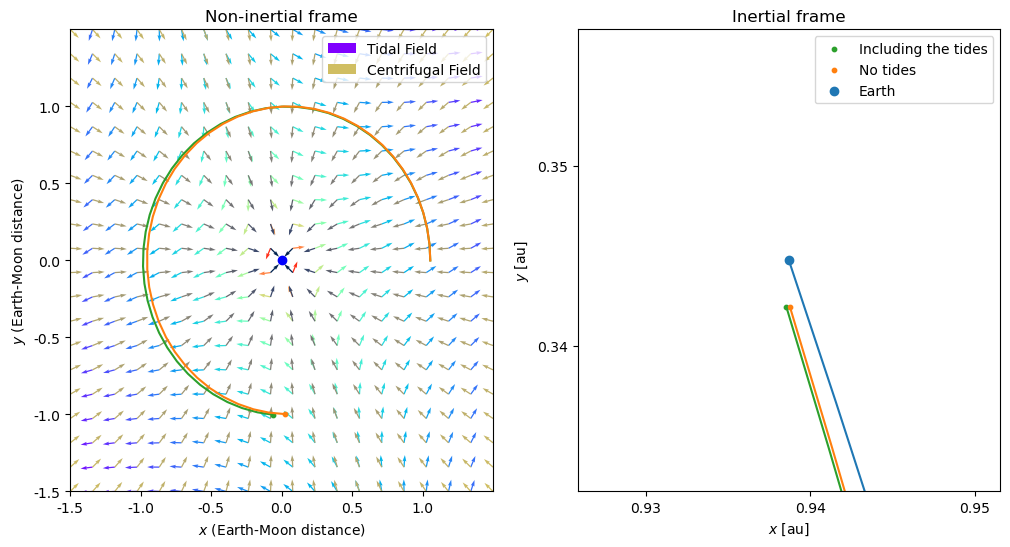

In [277]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[1].plot(inertial_tidal_solution[0,down_index:sim_index+1], inertial_tidal_solution[1,down_index:sim_index+1], **PLOT_TIDAL)
ax[1].scatter(inertial_tidal_solution[0,sim_index], inertial_tidal_solution[1,sim_index], **SCAT_TIDAL)
ax[1].plot(inertial_rotating_solution[0,down_index:sim_index+1], inertial_rotating_solution[1,down_index:up_index+1], **PLOT_NONTIDAL)
ax[1].scatter(inertial_rotating_solution[0,sim_index], inertial_rotating_solution[1,sim_index], **SCAT_NONTIDAL)
ax[1].plot(earthsOrbit[0,down_index:sim_index+1], earthsOrbit[1,down_index:sim_index+1],color='tab:blue', )
ax[1].scatter(earthsOrbit[0,sim_index], earthsOrbit[1,sim_index],  color='tab:blue', label='Earth')
ax[1].set(**AXIS2);
ax[0].set(**AXIS1);
ax[1].legend()
# turn off the label
SCAT_TIDAL["label"] = None
SCAT_NONTIDAL["label"] = None


ax[0].quiver(X.flatten(), Y.flatten(), tidal_force[0]/tidal_force_magnitude, tidal_force[1]/tidal_force_magnitude,color=colors_tidal, **QUIV_TIDAL)
ax[0].quiver(X.flatten(), Y.flatten(), centrifugalforce[0]/centrifugalforce_magnitude, centrifugalforce[1]/centrifugalforce_magnitude,color=colors_centrifugal, **QUIV_CENTRIFUGAL)
# plot the earth
ax[0].scatter(0,0, color='blue', label=None)
ax[0].plot(tidal_solution.y[0,down_index:sim_index+1], tidal_solution.y[1,down_index:sim_index+1], **PLOT_TIDAL)
ax[0].scatter(tidal_solution.y[0,sim_index], tidal_solution.y[1,sim_index], **SCAT_TIDAL)
ax[0].plot(rotating_two_body_solution.y[0,down_index:sim_index+1], rotating_two_body_solution.y[1,down_index:up_index+1], **PLOT_NONTIDAL)
ax[0].scatter(rotating_two_body_solution.y[0,sim_index], rotating_two_body_solution.y[1,sim_index], **SCAT_NONTIDAL)
ax[0].legend()


show the princpal result of how the tides cause a non negligible drift in moon phase, which is probably the most important for human life

In [43]:
phase_tides = np.arctan2(tidal_solution.y[1], tidal_solution.y[0])
phase_rotating = np.arctan2(rotating_two_body_solution.y[1], rotating_two_body_solution.y[0])
phase_tides_unwrapped = np.unwrap(phase_tides)
phase_rotating_unwrapped = np.unwrap(phase_rotating)

# Spherical case
Try to show that the longest eigen vector of the tidal tensor will always align with the radial vector 

In [6]:
# Variables
x, y, z, G, M = sp.symbols('x y z G M')
r = sp.sqrt(x**2 + y**2 + z**2)

# Potential
Phi = -G*M/r

# Force = grad(Phi)
grad_Phi = [sp.diff(Phi, var) for var in (x, y, z)]

# Hessian (tidal tensor)
tidal_tensor = -sp.Matrix([
    [sp.diff(grad_Phi[i], var) for var in (x, y, z)]
    for i in range(3)
])

tidal_tensor

Matrix([
[3*G*M*x**2/(x**2 + y**2 + z**2)**(5/2) - G*M/(x**2 + y**2 + z**2)**(3/2),                                    3*G*M*x*y/(x**2 + y**2 + z**2)**(5/2),                                    3*G*M*x*z/(x**2 + y**2 + z**2)**(5/2)],
[                                   3*G*M*x*y/(x**2 + y**2 + z**2)**(5/2), 3*G*M*y**2/(x**2 + y**2 + z**2)**(5/2) - G*M/(x**2 + y**2 + z**2)**(3/2),                                    3*G*M*y*z/(x**2 + y**2 + z**2)**(5/2)],
[                                   3*G*M*x*z/(x**2 + y**2 + z**2)**(5/2),                                    3*G*M*y*z/(x**2 + y**2 + z**2)**(5/2), 3*G*M*z**2/(x**2 + y**2 + z**2)**(5/2) - G*M/(x**2 + y**2 + z**2)**(3/2)]])

Note that sympy is having a hard time doing all the algebraic manipulations, like finding the eigen vectors. I will simplify this expression to find the tidal tensor. This can be done by replacing $x^2 + y^2 + z^2$ with $r^2$ and factoring out  $\frac{GM}{r^3}$ This way, I can have a "scaled" tidal tensor.

Note that below I introduce $r$ without establishing that it is $r^2=x^2 + y^2 + z^2$. With SymPy, this manouver keeps the equation neat and orderly. 

In [7]:
r,x,y,z=sp.symbols('r x y z', real=True)
T = -sp.Matrix(
    [1 - 3*x**2/r**2, 
     -3*x*y/r**2, 
     -3*x*z/r**2,
     -3*x*y/r**2,
     1 - 3*y**2/r**2,
     -3*y*z/r**2,
     -3*x*z/r**2,
     -3*y*z/r**2,
     1 - 3*z**2/r**2]
)
scaled_tidal_tensor=T.reshape(3,3)


Now create numpy functions from sympy 

In [8]:
scaled_tidal_tensor_func = sp.lambdify((r, x, y, z), scaled_tidal_tensor, "numpy")

## Play with the tidal field for the moon

There are many ways that the moon and the tides play together. The tides from the earth deform the shape of the moon, and thus the moon is tidally locked. The tides from the moon "fix" the Earth's water in an ellipse as the earth then moves around it. But, I want to know how much the moons orbit could deviate given the tidal field of the sun. 

Things to consider 
- The Earth has a non intertial reference frame as it orbits the sun 
- the moon-earth distance
- the gravitational strength of the earth
- the solar tidal field 

I want to compute the orbits of the moon by continually adding more corrections: 
1. The two body problem 
2. The tidal froces from the sun while in the earth's reference frame. 


Q. What is stronger? the tidal force or the centrigufal force? I wonder! 

In [6]:
const.M_sun

<<class 'astropy.constants.iau2015.IAU2015'> name='Solar mass' value=1.988409870698051e+30 uncertainty=4.468805426856864e+25 unit='kg' reference='IAU 2015 Resolution B 3 + CODATA 2018'>

In [9]:
# pick the units
unitL = u.au
unitT = u.yr
unitV = unitL / unitT
unitM = u.Msun
unitG=unitV**2 * unitL / unitM
G_val=const.G.to(unitG)
# Pick some values 
Msun = 1*u.Msun
Mearth= (1*u.Mearth).to(u.Msun)
Dearth= 1*u.au
Dmoon = 384400 * u.km # from google 
Dmoon = Dmoon.to(u.au)
omega = 2*np.pi / (1 * u.yr)
# drop the units 
Msun = Msun.value
Mearth = Mearth.value
Dearth = Dearth.value
Dmoon = Dmoon.value
omega = omega.value
G_val = G_val.value
# numerical parametesr 
npoints = 25

In [10]:
# pick a position of the earth 
time = 0.1
x_earth = Dearth * np.cos(omega * time)
y_earth = Dearth * np.sin(omega * time)
z_earth = 0
r_earth = np.sqrt(x_earth**2 + y_earth**2 + z_earth**2)
# eval the tidal tensor at the position of the earth
unscaled_tidal_tensor=scaled_tidal_tensor_func(r_earth, x_earth, y_earth, z_earth)
# scale the tidal tensor
tidal_tensor = unscaled_tidal_tensor * (G_val * Msun / Dearth**3)
# get the eigen vectors of the tidal tensor
unscaled_eigen = np.linalg.eig(unscaled_tidal_tensor)
eigen = np.linalg.eig(tidal_tensor)

In [11]:
# create a unit sphere 
npoints = 25
x_sphere = Dmoon*np.cos(np.linspace(0, 2 * np.pi, npoints))
y_sphere = Dmoon*np.sin(np.linspace(0, 2 * np.pi, npoints))
# scale them based on the eigenvalues
scaled_eigen = np.sqrt(np.abs(unscaled_eigen.eigenvalues))
x_sphere = scaled_eigen[0] * x_sphere
y_sphere = scaled_eigen[1] * y_sphere
# rotate the sphere based on the eigenvectors
surface_points = np.vstack([x_sphere.ravel(), y_sphere.ravel(), np.zeros_like(x_sphere.ravel())])
# rotate the points using the rotation matrix
rotation_matrix = np.array(unscaled_eigen.eigenvectors)  # Transpose to match the correct rotation convention
rotated_points = rotation_matrix.dot(surface_points)

In [12]:
# set the grid to evaulate the tidal forces around the earth
delta = 2*Dmoon
xs = np.linspace(-delta, delta, npoints)
ys = np.linspace(-delta, delta, npoints)
X, Y = np.meshgrid(xs, ys)
# prepare the vector outputs 
tidal_vectors = np.zeros((X.shape[0], X.shape[1], 3))  # For storing vectors
# make a list of coordinates
coords = np.zeros((3,X.flatten().shape[0]))
# fill in the coordinates
coords[0] = X.flatten()
coords[1] = Y.flatten()
coords[2] = np.zeros_like(X.flatten())
# compute the dot product 
tidal_force_vectors=tidal_tensor.dot(coords)
# Normalize the vectors
tidal_force_magnitude=np.linalg.norm(tidal_force_vectors, axis=0)
normalized_tidal_forces = tidal_force_vectors / tidal_force_magnitude
# compute the force from the earth 
distance_to_earth = np.sum(coords**2, axis=0)**0.5
earth_force_magnitude = (G_val*Mearth) * (1/distance_to_earth**2)
earth_force = -coords * earth_force_magnitude / distance_to_earth
normalized_earth_force = earth_force / earth_force_magnitude

# make the field for the centrifugal force

omega_vec = np.array([0, 0, omega])
centrifugalforce=-np.cross(omega_vec,np.cross(omega_vec.T, coords.T)).T
centrifugalforce_magnitude = np.linalg.norm(centrifugalforce, axis=0)
# Normalize the vectors
normalized_centrifugalforce = centrifugalforce / centrifugalforce_magnitude


# make the net force vector 
net_force = tidal_force_vectors + earth_force + centrifugalforce
# normalize each of them 
norm_net_force = np.linalg.norm(net_force, axis=0)
normalized_net_force = net_force / norm_net_force

/var/folders/vt/72vlp8hj577dnzr1gl35j41c0000gn/T/ipykernel_73318/4025443617.py:18: RuntimeWarning: invalid value encountered in divide
  normalized_tidal_forces = tidal_force_vectors / tidal_force_magnitude
/var/folders/vt/72vlp8hj577dnzr1gl35j41c0000gn/T/ipykernel_73318/4025443617.py:21: RuntimeWarning: divide by zero encountered in divide
  earth_force_magnitude = (G_val*Mearth) * (1/distance_to_earth**2)
/var/folders/vt/72vlp8hj577dnzr1gl35j41c0000gn/T/ipykernel_73318/4025443617.py:22: RuntimeWarning: invalid value encountered in multiply
  earth_force = -coords * earth_force_magnitude / distance_to_earth
/var/folders/vt/72vlp8hj577dnzr1gl35j41c0000gn/T/ipykernel_73318/4025443617.py:31: RuntimeWarning: invalid value encountered in divide
  normalized_centrifugalforce = centrifugalforce / centrifugalforce_magnitude


In [13]:
# make a colormap for the magnitude of the force
vmax = 20
vmin = .1
mycmap = mpl.colormaps.get_cmap('rainbow_r')
norm = mpl.colors.LogNorm(vmin=vmin, vmax=vmax)
colors_tidal = [mycmap(norm(force)) for force in tidal_force_magnitude]
colors_earth = mycmap(norm(earth_force_magnitude))
colors_centrifugal = mycmap(norm(centrifugalforce_magnitude))
AXIS={
    "xlim": (x_earth-delta, x_earth+delta),
    "ylim": (y_earth-delta, y_earth+delta),
    "aspect": "equal",
    "xlabel": "X [kpc]",
    "ylabel": "Y [kpc]",}

In [14]:
import matplotlib.font_manager as fm
# Check if the new font is now available
available_fonts = [f.name for f in fm.fontManager.ttflist]
emoji_fonts = [f for f in available_fonts if 'emoji' in f.lower() or 'noto' in f.lower()]
print("Available emoji fonts:", emoji_fonts)
emoji_font = fm.FontProperties(family='Noto Color Emoji')


Available emoji fonts: ['Noto Sans Gothic', 'Noto Serif Myanmar', 'Noto Sans Yi', 'Noto Sans Imperial Aramaic', 'Noto Sans Lycian', 'Noto Sans Modi', 'Noto Sans Khojki', 'Noto Sans Rejang', 'Noto Sans Hatran', 'Noto Sans Saurashtra', 'Noto Sans Bassa Vah', 'Noto Sans Newa', 'Noto Sans Batak', 'Noto Sans Egyptian Hieroglyphs', 'Noto Sans Kannada', 'Noto Sans Osmanya', 'Noto Sans Samaritan', 'Noto Sans Mandaic', 'Noto Sans Linear B', 'Noto Sans Syriac', 'Noto Sans PhagsPa', 'Noto Sans Marchen', 'Noto Sans Bhaiksuki', 'Noto Sans Coptic', 'Noto Sans Tifinagh', 'Noto Sans Linear A', 'Noto Sans Limbu', 'Noto Sans Carian', 'Noto Sans Old Permic', 'Noto Sans Sora Sompeng', 'Noto Sans Syloti Nagri', 'Noto Sans Cuneiform', 'Noto Sans Meroitic', 'Noto Sans Tagalog', 'Noto Serif Balinese', 'Noto Sans Chakma', 'Noto Sans Cham', 'Noto Sans Glagolitic', 'Noto Sans Phoenician', 'Noto Sans Gunjala Gondi', 'Noto Sans Lepcha', 'Noto Sans Mro', 'Noto Sans New Tai Lue', 'Noto Sans Ugaritic', 'Noto Sans Mul

In [15]:
# Add this at the top of your notebook
from matplotlib import offsetbox
from PIL import Image
from urllib.request import urlopen
import io

# Download a small earth image or use a local one
url = "https://upload.wikimedia.org/wikipedia/commons/thumb/c/cb/The_Blue_Marble_%28remastered%29.jpg/240px-The_Blue_Marble_%28remastered%29.jpg"
img_data = urlopen(url).read()
img = Image.open(io.BytesIO(img_data))

# For your plotting code
earth_img = offsetbox.OffsetImage(img, zoom=0.1)


In [16]:
unitAccel=unitG*unitM/unitL**2

unitAccel.to_string()

'AU / yr2'

In [17]:
unitV/unitT

Unit("AU / yr2")

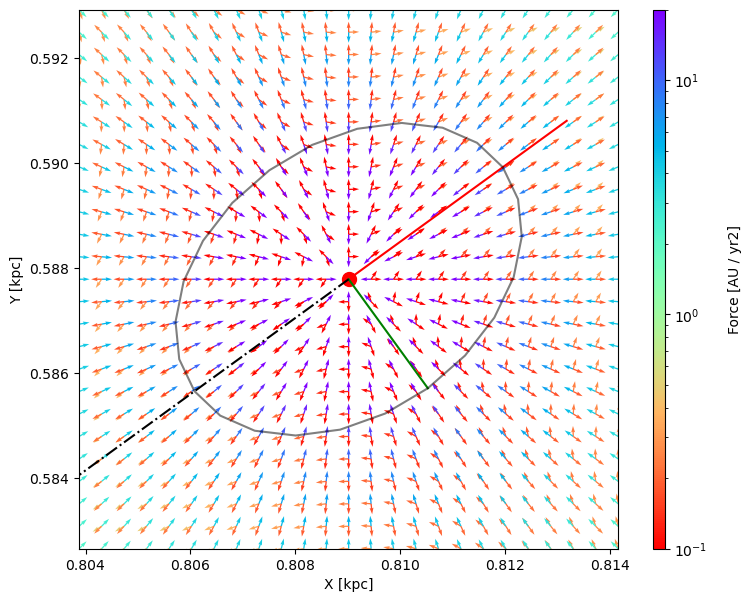

In [18]:
# plot the tidal field about the earth 
fig=plt.figure(figsize=(8, 7))
gs=fig.add_gridspec(1, 2, width_ratios=[1, 1/50],wspace=0)
axis=fig.add_subplot(gs[0, 0])
cax=fig.add_subplot(gs[0, 1])
im=axis.quiver(x_earth+X.flatten(), y_earth+Y.flatten(), normalized_tidal_forces[0], normalized_tidal_forces[1], color=colors_tidal,units="xy",scale=5000  )
axis.quiver(x_earth+X.flatten(), y_earth+Y.flatten(), normalized_earth_force[0], normalized_earth_force[1], color=colors_earth,units="xy",scale=5000  )
axis.quiver(x_earth+X.flatten(), y_earth+Y.flatten(), normalized_centrifugalforce[0], normalized_centrifugalforce[1], color=colors_centrifugal,units="xy",scale=5000  )
axis.scatter(x_earth, y_earth, color='r', s=100)
# add the eigen vectors 
axis.plot([x_earth,x_earth+Dmoon*unscaled_eigen.eigenvalues[0]*unscaled_eigen.eigenvectors[0][0]],[y_earth,y_earth+Dmoon*unscaled_eigen.eigenvalues[0]*unscaled_eigen.eigenvectors[1][0]],'-', color='r')
axis.plot([x_earth,x_earth+Dmoon*unscaled_eigen.eigenvalues[1]*unscaled_eigen.eigenvectors[0][1]],[y_earth,y_earth+Dmoon*unscaled_eigen.eigenvalues[1]*unscaled_eigen.eigenvectors[1][1]],'-', color='g')
axis.plot([x_earth,x_earth+Dmoon*unscaled_eigen.eigenvalues[2]*unscaled_eigen.eigenvectors[2][0]],[y_earth,y_earth+Dmoon*unscaled_eigen.eigenvalues[2]*unscaled_eigen.eigenvectors[2][1]],'-', color='b')

sm=plt.cm.ScalarMappable(cmap=mycmap, norm=norm)
sm.set_array([])  # You need to set an array, even if empty
cbar=fig.colorbar(sm, cax=cax, orientation='vertical')
cbar.set_label('Force [{:s}]'.format(unitAccel.to_string()), rotation=90, labelpad=15)

# add the eart 
# earth_annotation = offsetbox.AnnotationBbox(earth_img, (x_earth, y_earth), frameon=False)
# axis.add_artist(earth_annotation)

axis.plot([0,x_earth],[0,y_earth],'-.', color='k')
# add the deformed shape 
axis.plot(x_earth+rotated_points[0],y_earth+rotated_points[1], color='k', alpha=0.5)

axis.set(**AXIS);

In [19]:
AXIS2 = {
    "xlim": (-Dearth, Dearth),
    "ylim": (-Dearth, Dearth),
    "aspect": "equal",
    "xlabel": "X [au]",
    "ylabel": "Y [au]",
}

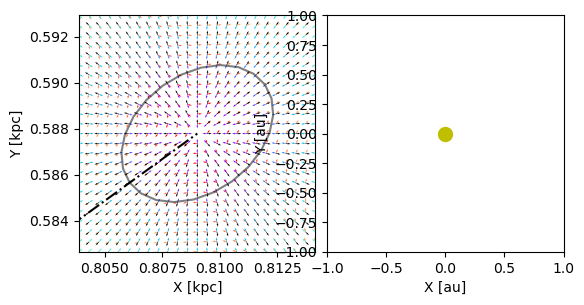

In [20]:
fig=plt.figure(figsize=(8.25-2, (11.75-2)/3))
gs = mpl.gridspec.GridSpec(1, 2, width_ratios=[1, 1], wspace=0.05)
axis1 = fig.add_subplot(gs[0])
axis2 = fig.add_subplot(gs[1])
axis1.quiver(x_earth+X.flatten(), y_earth+Y.flatten(), normalized_tidal_forces[0], normalized_tidal_forces[1], color=colors_tidal,units="xy",scale=5000  )
axis1.quiver(x_earth+X.flatten(), y_earth+Y.flatten(), normalized_earth_force[0], normalized_earth_force[1], color=colors_earth,units="xy",scale=5000  )
axis1.quiver(x_earth+X.flatten(), y_earth+Y.flatten(), normalized_centrifugalforce[0], normalized_centrifugalforce[1], color='k',units="xy",scale=5000  )
axis1.plot([0,x_earth],[0,y_earth],'-.', color='k')
axis1.set(**AXIS);
axis1.plot(x_earth+rotated_points[0], y_earth+rotated_points[1], color='k', alpha=0.5)
# add the positions 
# axis2.scatter(x_earth, y_earth, color='b', s=10)
axis2.scatter(0,0, color='y', s=100)
axis2.set(**AXIS2);

# Solve the equations of motion 
$$ \ddot{r}_\text{moon,earth} = -\nabla \Phi(r_\text{moon,earth})_{\text{Earth}} - T_\odot(r_\text{earth,sun}) \cdot \vec{r}_\text{moon,earth} - \vec{\omega} \times \left(\vec{\omega} \times {\vec{r}_{\text{moon,sun}}}\right)$$ 

We can use scipy's `solve_ivp`  since orbits are initial value problems of ordinary differential equations. Since I need to evaluate the position of the earth a function of time, the equations of motion will not be a set of autonomous differentia equations. They will depend on time 

In [21]:
from scipy import integrate

In [22]:
r,x,y,z=sp.symbols('r x y z', real=True)
T = -sp.Matrix(
    [1 - 3*x**2/r**2, 
     -3*x*y/r**2, 
     -3*x*z/r**2,
     -3*x*y/r**2,
     1 - 3*y**2/r**2,
     -3*y*z/r**2,
     -3*x*z/r**2,
     -3*y*z/r**2,
     1 - 3*z**2/r**2]
)
scaled_tidal_tensor=T.reshape(3,3)
scaled_tidal_tensor_func = sp.lambdify((r, x, y, z), scaled_tidal_tensor, "numpy")

def system_of_equations(t, y, G_val, Mearth, omega, Msun, scaled_tidal_tensor_func):
    # unpack the state of the system 
    position_moon = y[:3]
    velocity_moon = y[3:]
    omega_vec = np.array([0, 0, omega])
    # get the current position of the earth
    x_earth = Dearth * np.cos(omega * t)
    y_earth = Dearth * np.sin(omega * t)
    z_earth = 0
    position_earth = np.array([x_earth, y_earth, z_earth])
    r_earth = np.linalg.norm(position_earth)
    # eval the tidal tensor at the position of the earth
    tidal_tensor = -(G_val*Msun/r_earth**3)*scaled_tidal_tensor_func(r_earth, position_earth[0], position_earth[1], position_earth[2])
    tidal_force = tidal_tensor.dot(position_moon)
    # evaluate the centrifugal force
    centrifugalforce = - np.cross(omega_vec, np.cross(omega_vec.T, position_moon.T).T)
    # evaluate the force from the earth
    moon_earth_distance = np.linalg.norm(position_moon)
    earth_force=-(G_val*Mearth / moon_earth_distance**3) * position_moon
    # get the net force 
    net_force = tidal_force + centrifugalforce + earth_force
    # stack up everything 
    ydot = np.concatenate([velocity_moon, net_force])
    return ydot

def two_body_rotating_frame_system_of_equations(t, y, G_val, Mearth, omega):
    # unpack the state of the system 
    position_moon = y[:3]
    velocity_moon = y[3:]
    omega_vec = np.array([0, 0, omega])
    # evaluate the centrifugal force
    centrifugalforce = - np.cross(omega_vec, np.cross(omega_vec.T, position_moon.T).T)
    # evaluate the force from the earth
    moon_earth_distance = np.linalg.norm(position_moon)
    earth_force=-(G_val*Mearth / moon_earth_distance**3) * position_moon
    # get the net force 
    net_force =  earth_force + centrifugalforce
    # stack up everything 
    ydot = np.concatenate([velocity_moon, net_force])
    return ydot

def two_body_system_of_equations(t,y, G_val, Mearth):
    # unpack the state of the system 
    position_moon = y[:3]
    velocity_moon = y[3:]
    # evaluate the force from the earth
    moon_earth_distance = np.linalg.norm(position_moon)
    earth_force=-(G_val*Mearth / moon_earth_distance**3) * position_moon
    # get the net force 
    net_force =   earth_force
    # stack up everything 
    ydot = np.concatenate([velocity_moon, net_force])
    return ydot

In [ ]:
# pick the initial conditions of the moon w.r.t. the earth
# build the initial conditions of the moon from https://nssdc.gsfc.nasa.gov/planetary/factsheet/moonfact.html
semi_major_axis = 0.3844 * 1e6 * u.km
eccentricity = 0.0549 
inclination = 5.145*u.deg
# convert the units
semi_major_axis=semi_major_axis.to(unitL).value
inclination=inclination.to(u.rad).value
# get the apogee
ra = (1+eccentricity) * semi_major_axis
# get the spped at apogee
v_apogee = np.sqrt(G_val*Mearth * (2/ra - 1/semi_major_axis))
# put them in vectors
position_moon = np.array([ra, 0, 0])
velocity_moon = np.array([0, v_apogee, 0])
# make a rotation matrix about the x-axis
rotation_matrix = np.array([[1, 0, 0],
                              [0, np.cos(inclination), -np.sin(inclination)],
                              [0, np.sin(inclination), np.cos(inclination)]])
# rotate the position and velocity vectors
position_moon = rotation_matrix.dot(position_moon)
velocity_moon = rotation_matrix.dot(velocity_moon)
# package the phase space coordinates
y0 = np.concatenate([position_moon, velocity_moon])

In [ ]:
t_span = (0, 4) # two years 
rtol=1e-10
atol=1e-10
t_eval_n_points = 1000
t_eval=np.linspace(t_span[0], t_span[1], t_eval_n_points)
solution_all = integrate.solve_ivp(
    system_of_equations, 
    t_span, 
    y0, 
    args=(G_val, Mearth, omega, Msun, scaled_tidal_tensor_func), 
    t_eval=t_eval, 
    rtol=rtol,
    atol=atol
)
solution_rotating = integrate.solve_ivp(
    two_body_rotating_frame_system_of_equations, 
    t_span, 
    y0, 
    args=(G_val, Mearth, omega), 
    t_eval=t_eval, 
    rtol=rtol,
    atol=atol
)
solution_two_body = integrate.solve_ivp(
    two_body_system_of_equations, 
    t_span, 
    y0, 
    args=(G_val, Mearth), 
    t_eval=t_eval, 
    rtol=rtol,
    atol=atol
)

In [49]:
# get the phase angle for each 
phase_all = np.arctan2(solution_all.y[1], solution_all.y[0])
phase_rotating = np.arctan2(solution_rotating.y[1], solution_rotating.y[0])
phase_two_body = np.arctan2(solution_two_body.y[1], solution_two_body.y[0])
# unwrap the phase angles to avoid discontinuities at ±π
phase_all = np.unwrap(phase_all)
phase_rotating = np.unwrap(phase_rotating)
phase_two_body = np.unwrap(phase_two_body)

In [66]:
dphase=(180/np.pi)*(phase_rotating-phase_all)
AXIS = {
    "ylabel": r"$\Delta$ Moon Phase [degrees]",
    "xlabel": "Time [years]",
    "xlim": (0, 4),
    "ylim": (0, 180),
    "yticks": np.arange(0, 181, 30),
    "yticklabels": [f"{int(tick)}" for tick in np.arange(0, 181, 30)],
    "xticks": np.arange(0, 5, 1),
    "xticklabels": [f"{int(tick)}" for tick in np.arange(0, 5, 1)],
    "title": "Orbital Moon Drift due to the Sun's Tidal Forces",
}

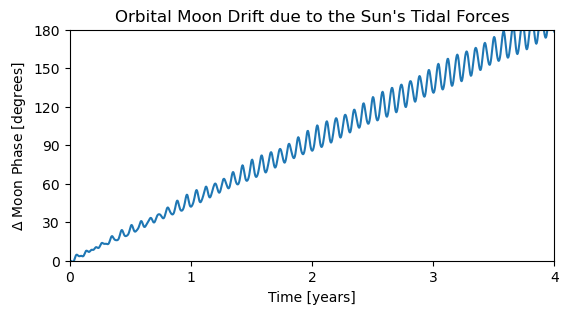

In [68]:
fig,axis=plt.subplots(figsize=(8.25-2, 3))
axis.plot(solution_all.t, dphase, label='x')
axis.set(**AXIS);

In [ ]:
# lets' get all the proper data
# the second plot will get the position of the earth at a given instant 

In [ ]:
.shape

(1000,)

In [84]:
t = 2.3
xearth = Dearth * np.cos(omega * t)
yearth = Dearth * np.sin(omega * t)
zearth = 0

pos_earth = np.zeros((3, t_eval_n_points))
pos_earth[0] = Dearth * np.cos(omega*t_eval)
pos_earth[1] = Dearth * np.sin(omega*t_eval)

# back index the time
back_width = 10

NameError: name 't_eval_n_points' is not defined

In [81]:
pos_earth.shape

(3, 25)

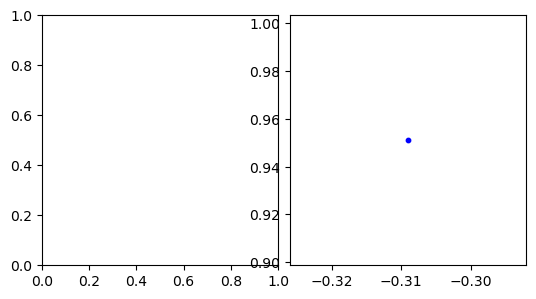

In [77]:
def set_up_plot():
    fig=plt.figure(figsize=(8.25-2, (11.75-2)/3))
    gs = mpl.gridspec.GridSpec(1, 2, width_ratios=[1, 1], wspace=0.05)
    axis1 = fig.add_subplot(gs[0])
    axis2 = fig.add_subplot(gs[1])
    return fig, axis1, axis2

fig, axis1, axis2 = set_up_plot()


axis2.scatter(xearth, yearth, color='b', s=10)